In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_theme(style="whitegrid")

In [2]:
#Load all datasets
# Main Dataset

# Conversation Data -- we will use this data in the "Conversation Data" section
df = pd.read_json(
    "../data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip"
)
df.head(5)
# Auxiliary Datasets

# Embedding Data -- we will use this data in the "Embedding Data" section
prompt_embeddings = np.load(
    "../data/training-set/chatbot-arena-prompts-embeddings.npy"
)

response_a_embeddings = np.load(
    "../data/training-set/chatbot-arena-model_a_response-embeddings.npy"
)

response_b_embeddings = np.load(
    "../data/training-set/chatbot-arena-model_b_response-embeddings.npy"
)

# Topic Modeling and Hardness Score Data -- we will use this data in the "Topic Modeling and Hardness Score Data" section
topic_and_hardness = pd.read_json(
    "../data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip"
)

In [3]:
no_ties = df[(df['winner'] != 'tie') & (df['winner'] != 'tie (bothbad)')]

In [72]:
cnt = 0
wins = 0
for index, row in no_ties.iterrows():
    if (row['model_a'] == 'gpt-4' and row['model_b'] == 'llama-13b') or (row['model_a'] == 'llama-13b' and row['model_b'] == 'gpt-4'):
        cnt += 1
        if (row['model_a'] == 'gpt-4' and row['winner'] == 'model_a') or (row['model_b'] == 'gpt-4' and row['winner'] == 'model_b'):
            wins += 1
    
print(cnt)
print(wins/cnt)

69
0.9710144927536232


In [4]:
battle_counts = pd.pivot_table(no_ties, index='model_a', columns='model_b', values='winner', aggfunc='count', fill_value=0, margins=True)
battle_counts = battle_counts + battle_counts.T
ordered_battle_counts = battle_counts.sort_values(by='All', ascending=False).drop('All', axis=1).sort_values(by='All', axis=1, ascending=False).drop('All', axis=0)
# ordered_battle_counts = battle_counts.sort_values(by='', key=lambda x: x.sum(), axis=0, ascending=False)
ordered_battle_counts

model_b,vicuna-13b,koala-13b,gpt-3.5-turbo,oasst-pythia-12b,gpt-4,alpaca-13b,claude-v1,RWKV-4-Raven-14B,chatglm-6b,fastchat-t5-3b,palm-2,stablelm-tuned-alpha-7b,claude-instant-v1,mpt-7b-chat,dolly-v2-12b,vicuna-7b,llama-13b,wizardlm-13b,guanaco-33b,gpt4all-13b-snoozy
model_a,,,,,,,,,,,,,,,,,,,,
vicuna-13b,0,411,210,328,207,236,179,171,203,132,110,182,108,119,197,96,172,35,33,39
koala-13b,411,0,246,242,214,222,194,139,151,137,131,151,97,115,164,91,124,28,22,26
gpt-3.5-turbo,210,246,0,218,172,207,185,202,147,174,128,114,90,122,135,122,92,46,41,43
oasst-pythia-12b,328,242,218,0,233,174,201,116,157,109,105,129,96,98,126,69,100,49,43,31
gpt-4,207,214,172,233,0,182,165,201,162,152,116,141,87,147,113,121,69,33,42,41
alpaca-13b,236,222,207,174,182,0,201,121,159,115,88,126,84,72,121,73,100,24,19,22
claude-v1,179,194,185,201,165,201,0,196,133,127,113,85,69,127,87,116,60,37,20,47
RWKV-4-Raven-14B,171,139,202,116,201,121,196,0,78,79,107,66,92,87,51,83,40,40,40,20
chatglm-6b,203,151,147,157,162,159,133,78,0,73,76,75,77,57,88,49,62,10,21,18


<Axes: xlabel='model_b', ylabel='model_a'>

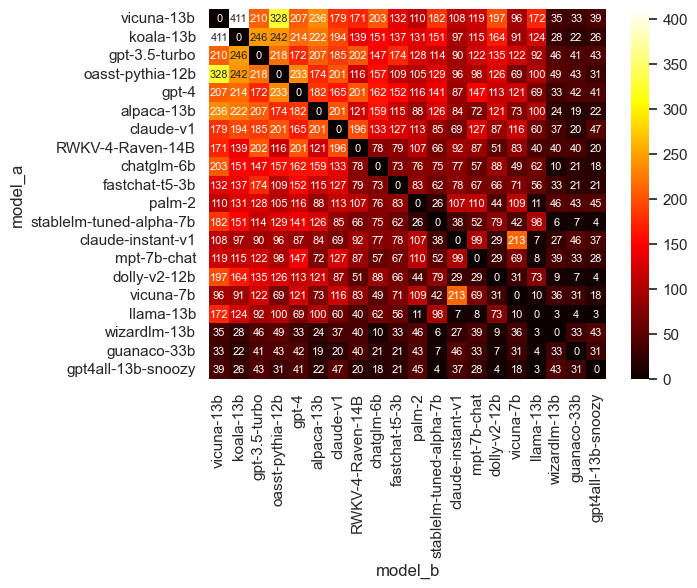

In [5]:
sns.heatmap(ordered_battle_counts, annot=True, fmt='d', cmap='hot', annot_kws={"size": 8})

In [6]:
win_rates = (pd.pivot_table(no_ties[no_ties['winner'] == 'model_a'], index='model_a', columns='model_b', values='winner', aggfunc='count', fill_value=0, margins=True) + pd.pivot_table(no_ties[no_ties['winner'] == 'model_b'], index='model_a', columns='model_b', values='winner', aggfunc='count', fill_value=0, margins=True).T) / battle_counts
win_rates = win_rates.fillna(0)
win_rates = win_rates.sort_values(by='All', ascending=False).drop('All', axis=1).sort_values(by='All', axis=1, ascending=False).drop('All', axis=0)
win_rates

model_b,llama-13b,dolly-v2-12b,stablelm-tuned-alpha-7b,fastchat-t5-3b,chatglm-6b,RWKV-4-Raven-14B,gpt4all-13b-snoozy,oasst-pythia-12b,alpaca-13b,mpt-7b-chat,vicuna-7b,koala-13b,wizardlm-13b,palm-2,guanaco-33b,vicuna-13b,gpt-3.5-turbo,claude-instant-v1,claude-v1,gpt-4
model_a,,,,,,,,,,,,,,,,,,,,
gpt-4,0.971014,0.955752,0.929078,0.914474,0.907407,0.890547,0.853659,0.909871,0.956044,0.918367,0.801653,0.859813,0.818182,0.775862,0.642857,0.879227,0.779070,0.689655,0.545455,0.000000
claude-v1,0.983333,0.942529,0.894118,0.960630,0.879699,0.862245,0.914894,0.885572,0.910448,0.874016,0.767241,0.783505,0.783784,0.725664,0.650000,0.793296,0.583784,0.507246,0.000000,0.454545
claude-instant-v1,0.571429,0.862069,0.973684,0.884615,0.909091,0.869565,0.702703,0.822917,0.821429,0.848485,0.812207,0.835052,0.740741,0.747664,0.782609,0.712963,0.566667,0.000000,0.492754,0.310345
gpt-3.5-turbo,0.945652,0.911111,0.912281,0.862069,0.897959,0.787129,0.674419,0.839450,0.884058,0.778689,0.737705,0.735772,0.695652,0.585938,0.439024,0.604762,0.000000,0.433333,0.416216,0.220930
vicuna-13b,0.877907,0.857868,0.824176,0.795455,0.837438,0.736842,0.717949,0.750000,0.788136,0.680672,0.541667,0.618005,0.542857,0.418182,0.454545,0.000000,0.395238,0.287037,0.206704,0.120773
guanaco-33b,0.750000,0.714286,0.857143,0.857143,0.714286,0.700000,0.838710,0.790698,0.684211,0.787879,0.612903,0.500000,0.636364,0.558140,0.000000,0.545455,0.560976,0.217391,0.350000,0.357143
palm-2,0.909091,0.909091,0.923077,0.783133,0.815789,0.813084,0.688889,0.771429,0.761364,0.700000,0.660550,0.687023,0.434783,0.000000,0.441860,0.581818,0.414062,0.252336,0.274336,0.224138
wizardlm-13b,0.666667,1.000000,0.833333,0.757576,0.600000,0.650000,0.604651,0.857143,0.750000,0.666667,0.638889,0.500000,0.000000,0.565217,0.363636,0.457143,0.304348,0.259259,0.216216,0.181818
koala-13b,0.846774,0.798780,0.794702,0.759124,0.741722,0.575540,0.846154,0.702479,0.684685,0.669565,0.417582,0.000000,0.500000,0.312977,0.500000,0.381995,0.264228,0.164948,0.216495,0.140187


[Text(0, 0.5, 'gpt-4'),
 Text(0, 1.5, 'claude-v1'),
 Text(0, 2.5, 'claude-instant-v1'),
 Text(0, 3.5, 'gpt-3.5-turbo'),
 Text(0, 4.5, 'vicuna-13b'),
 Text(0, 5.5, 'guanaco-33b'),
 Text(0, 6.5, 'palm-2'),
 Text(0, 7.5, 'wizardlm-13b'),
 Text(0, 8.5, 'koala-13b'),
 Text(0, 9.5, 'vicuna-7b'),
 Text(0, 10.5, 'mpt-7b-chat'),
 Text(0, 11.5, 'alpaca-13b'),
 Text(0, 12.5, 'oasst-pythia-12b'),
 Text(0, 13.5, 'gpt4all-13b-snoozy'),
 Text(0, 14.5, 'RWKV-4-Raven-14B'),
 Text(0, 15.5, 'chatglm-6b'),
 Text(0, 16.5, 'fastchat-t5-3b'),
 Text(0, 17.5, 'stablelm-tuned-alpha-7b'),
 Text(0, 18.5, 'dolly-v2-12b'),
 Text(0, 19.5, 'llama-13b')]

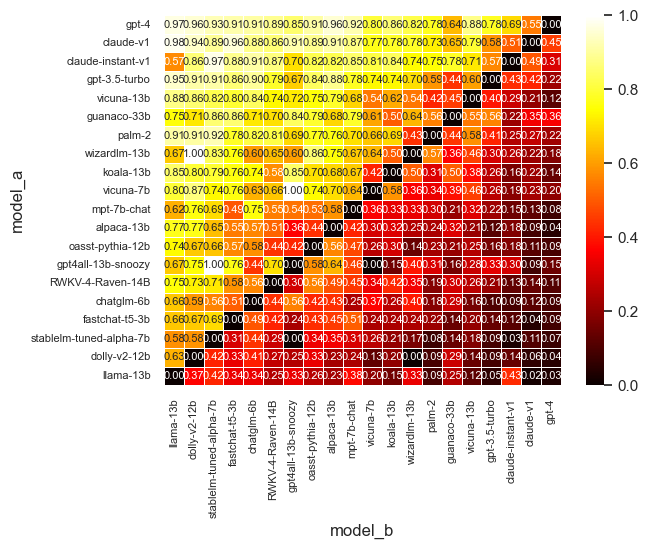

In [7]:
ax = sns.heatmap(win_rates, annot=True, fmt='.2f', cmap='hot', annot_kws={"size": 8}, linewidth=0.5)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

In [ ]:
# need to do model performance variance


In [8]:
models = pd.concat([df['model_a'], df['model_b']]).unique()
models

array(['chatglm-6b', 'oasst-pythia-12b', 'koala-13b', 'vicuna-13b',
       'stablelm-tuned-alpha-7b', 'alpaca-13b', 'llama-13b',
       'dolly-v2-12b', 'fastchat-t5-3b', 'gpt-3.5-turbo', 'gpt-4',
       'claude-v1', 'RWKV-4-Raven-14B', 'mpt-7b-chat', 'palm-2',
       'claude-instant-v1', 'vicuna-7b', 'wizardlm-13b',
       'gpt4all-13b-snoozy', 'guanaco-33b'], dtype=object)

In [ ]:
# check out model performance for different hardness scores



In [9]:
merge_df = pd.merge(df, topic_and_hardness, on='question_id')

In [10]:
def extract_digit(value):
    match = re.search(r"\d", str(value))  # Search for the first digit
    return int(match.group()) if match else None  # Return digit or None

# Apply the regex extraction to all relevant columns
for col in ["score_value_1", "score_value_2", "score_value_3"]:
    merge_df[col] = merge_df[col].apply(extract_digit)

merge_df["combined_hardness_score"] = (
    merge_df[["score_value_1", "score_value_2", "score_value_3"]]
    .mean(axis=1, skipna=True)  # Calculate mean while ignoring NaN values
)

In [165]:
appearances_a = merge_df[['model_a', 'combined_hardness_score']].rename(columns={'model_a': 'model'})
appearances_b = merge_df[['model_b', 'combined_hardness_score']].rename(columns={'model_b': 'model'})
appearances = pd.concat([appearances_a, appearances_b])
appearances_grouped = appearances.groupby(['model', 'combined_hardness_score']).agg('size').reset_index(name='appearances')
appearances_grouped

,model,combined_hardness_score,appearances
0,RWKV-4-Raven-14B,1.000000,4
1,RWKV-4-Raven-14B,1.333333,2
2,RWKV-4-Raven-14B,1.666667,16
3,RWKV-4-Raven-14B,2.000000,104
4,RWKV-4-Raven-14B,2.333333,23
...,...,...,...
491,wizardlm-13b,7.666667,132
492,wizardlm-13b,8.000000,184
493,wizardlm-13b,8.333333,78
494,wizardlm-13b,8.666667,49


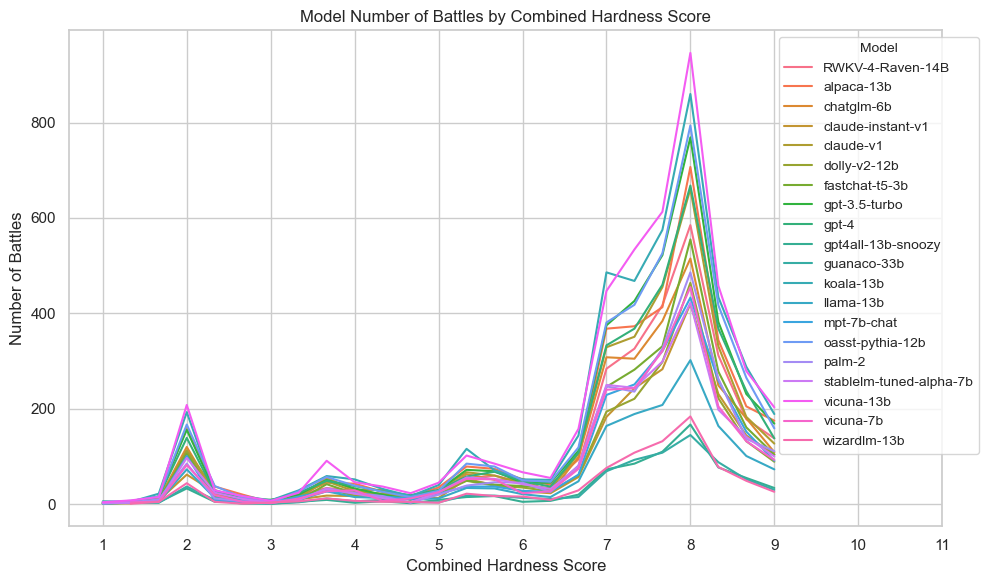

In [168]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=appearances_grouped, x='combined_hardness_score', y='appearances', hue='model', ax=ax)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper right', fontsize='small', title_fontsize='small')
plt.xticks(np.arange(1, 12, 1))
plt.title('Model Number of Battles by Combined Hardness Score')
plt.xlabel('Combined Hardness Score')
plt.ylabel('Number of Battles')
plt.tight_layout()

Text(0.5, 0.01, 'Combined Hardness Score')

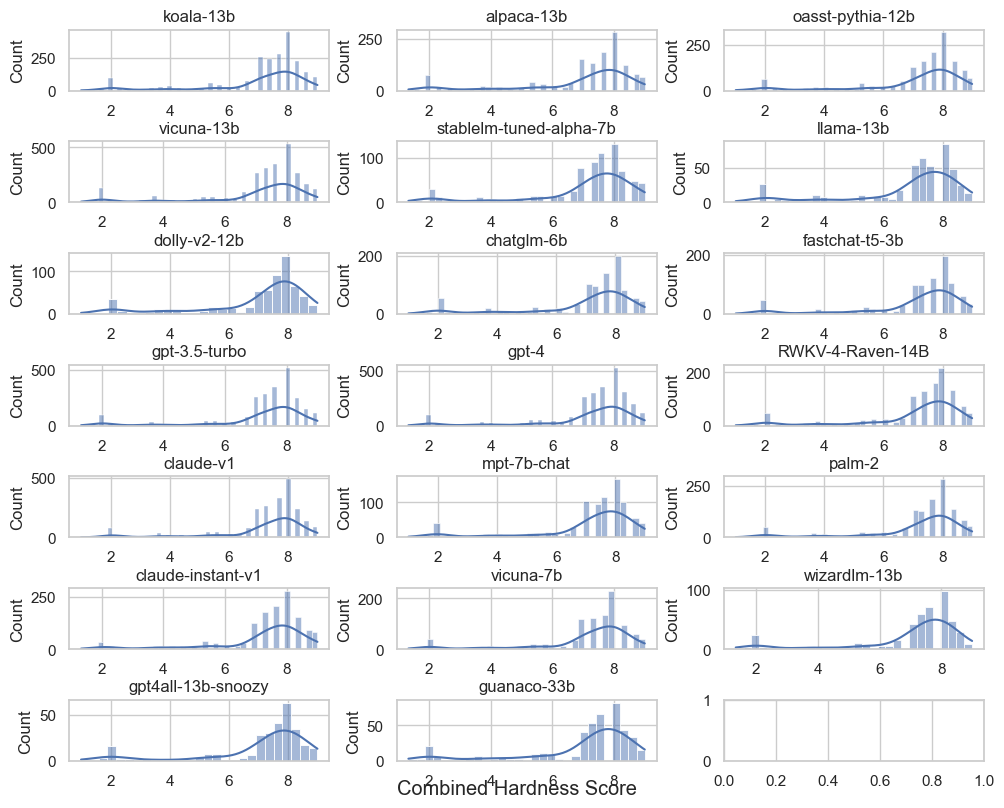

In [158]:
# figure out distribution of different users score models
merge_df['winning_model'] = merge_df.apply(lambda x: x['model_a'] if x['winner'] == 'model_a' else x['model_b'], axis=1)
winning_models = merge_df['winning_model'].unique()
model_combined_score = merge_df.groupby('winning_model')[['combined_hardness_score']].apply(lambda x: x).reset_index(level=1)

fig, axes = plt.subplots(7, 3, figsize=(10, 8))
fig.tight_layout()


for i in range(len(winning_models)):
    curr_model = winning_models[i]
    # plt.figure(i, figsize=(4, 3))
    sns.histplot(model_combined_score.loc[curr_model]['combined_hardness_score'], kde=True, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(curr_model)
    axes[i//3, i%3].set_xlabel('')
    # break
fig.supxlabel('Combined Hardness Score')

In [ ]:

# Identify users with missing values
users_with_missing_values = merge_df[merge_df.isnull().any(axis=1)]['winning_model'].unique()

# Identify users with outliers in combined_hardness_score
outlier_threshold = merge_df['combined_hardness_score'].mean() + 3 * merge_df['combined_hardness_score'].std()
users_with_outliers = merge_df[merge_df['combined_hardness_score'] > outlier_threshold]['winning_model'].unique()

In [12]:
merge_df

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,prompt,openai_scores_raw_choices_nested,topic_modeling_1,score_reason_1,score_value_1,topic_modeling_2,score_reason_2,score_value_2,topic_modeling_3,score_reason_3,score_value_3,combined_hardness_score
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,What is the difference between OpenCL and CUDA?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Technical Comparison,This prompt requires the AI to accurately comp...,9.0,Software Comparison,This prompt assesses the AI's factual accuracy...,8.0,"Comparison, Technology",This prompt requires the AI to demonstrate kno...,9.0,8.666667
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,Why did my parent not invite me to their wedding?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...","Reasoning, Emotion",This prompt requires the AI to understand huma...,9.0,"Emotions, Relationships",This prompt involves understanding complex hum...,8.0,"Reasoning, Emotional",This prompt challenges the AI to infer motives...,8.0,8.333333
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...","Fuji vs. Nikon, which is better?","[{'finish_reason': 'stop', 'index': 0, 'logpro...",Camera comparison,This prompt does not require problem-solving s...,2.0,Comparative Analysis,This prompt assesses the AI's ability to analy...,6.0,Photography comparison,This prompt is subjective and does not provide...,2.0,3.333333
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,How to build an arena for chatbots?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Chatbot Arena,This prompt requires problem-solving skills an...,8.0,Chatbot Arena,This prompt requires the AI to engage in probl...,8.0,Chatbot Arena,This prompt requires problem-solving skills an...,8.0,8.000000
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",When is it today?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Time Query,This prompt is very straightforward and does n...,2.0,Date Inquiry,This prompt is very straightforward and does n...,2.0,Time-based Inquiry,This prompt is too straightforward and simply ...,2.0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25297,fb4d58ef8649472783d364a9c1c8239e,palm-2,chatglm-6b,model_a,arena_user_21398,[{'content': 'If a tap is outputting 2500 ml a...,[{'content': 'If a tap is outputting 2500 ml a...,If a tap is outputting 2500 ml a minute. How m...,"[{'finish_reason': 'stop', 'index': 0, 'logpro...","Mathematics, Measurement",This prompt assesses the AI's ability in conve...,7.0,Mathematical Calculation,This prompt assesses the AI's problem-solving ...,7.0,"Mathematics, Problem-solving","This prompt requires converting units, perform...",8.0,7.333333
25298,8777c4945d85469d96cd26fc2ea6f64a,alpaca-13b,claude-instant-v1,tie,arena_user_21246,[{'content': 'who is the president of the U.S....,[{'content': 'who is the president of the U.S....,who is the president of the U.S.A?,"[{'finish_reason': 'stop', 'index': 0, 'logpro...",Information Retrieval,This prompt is a straightforward factual quest...,2.0,Factual Recall,This prompt solely tests the AI's ability to r...,2.0,Factual knowledge,This prompt simply tests basic factual knowled...,2.0,2.000000
25299,86063a921be548989c55b85497ab009a,claude-instant-v1,guanaco-33b,model_a,arena_user_20785,[{'con

In [14]:
# judge_name = "arena_user_973"  # Replace with the desired judge name

# judge_winners = merge_df[merge_df["judge"] == judge_name]["winner"].value_counts()

# judge_winners.plot(kind="bar")
# plt.xlabel("Model Winner")
# plt.ylabel("Count")
# plt.title(f"Distribution of Model Winners for Judge {judge_name}")
# plt.show()

merge_df.groupby("judge")["winning_model"].value_counts(normalize=True)

judge             winning_model   
arena_user_1000   vicuna-13b          0.555556
                  alpaca-13b          0.222222
                  dolly-v2-12b        0.111111
                  koala-13b           0.111111
arena_user_10002  RWKV-4-Raven-14B    0.500000
                                        ...   
arena_user_9995   gpt-3.5-turbo       0.250000
                  gpt-4               0.250000
                  mpt-7b-chat         0.250000
arena_user_9997   gpt-3.5-turbo       1.000000
arena_user_9999   claude-v1           1.000000
Name: proportion, Length: 18642, dtype: float64

In [25]:
merge_df.groupby("judge").agg('size').describe()

count    10531.000000
mean         2.402621
std          7.215953
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        307.000000
dtype: float64

In [29]:
merge_df.groupby("judge").agg('size').sort_values(ascending=False).head(10)

judge
arena_user_9965     307
arena_user_257      288
arena_user_13046    192
arena_user_3820     181
arena_user_15085    178
arena_user_11473    158
arena_user_6467     119
arena_user_6585     103
arena_user_1338     100
arena_user_13514     78
dtype: int64

In [40]:
print(merge_df.groupby("judge").agg('size').sort_values(ascending=False).head(10).sum())
print(merge_df.groupby("judge").agg('size').sort_values(ascending=False).head(20).sum())
print(merge_df.groupby("judge").agg('size').sort_values(ascending=False).head(50).sum())

1704
2425
3942


Text(0.5, 1.0, 'Cumulative Number of Battles per Judge')

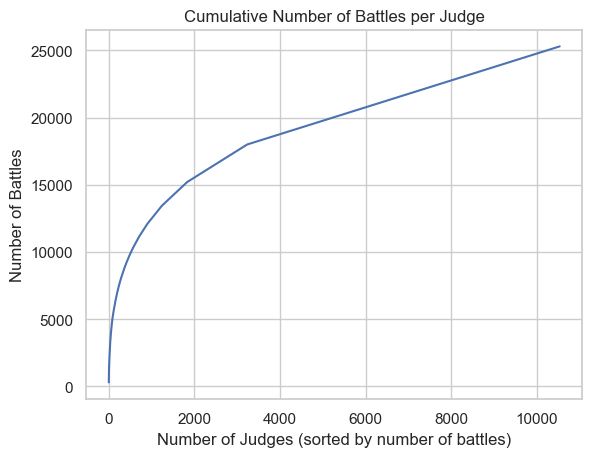

In [44]:
judge_cumulation = np.cumsum(merge_df.groupby("judge").agg('size').sort_values(ascending=False).values)
plt.plot(judge_cumulation)
plt.xlabel("Number of Judges (sorted by number of battles)")
plt.ylabel("Number of Battles")
plt.title("Cumulative Number of Battles per Judge")

In [63]:
merge_df['round_combined_hardness_score'] = merge_df['combined_hardness_score'].round()

In [66]:
merge_df.groupby('round_combined_hardness_score')[['winning_model']].value_counts(normalize=True)

round_combined_hardness_score  winning_model     
1.0                            oasst-pythia-12b      0.140625
                               claude-v1             0.078125
                               koala-13b             0.078125
                               mpt-7b-chat           0.078125
                               alpaca-13b            0.062500
                                                       ...   
9.0                            dolly-v2-12b          0.022286
                               guanaco-33b           0.017254
                               llama-13b             0.013659
                               wizardlm-13b          0.013659
                               gpt4all-13b-snoozy    0.011143
Name: proportion, Length: 180, dtype: float64

In [61]:
# get win percentage for each particular model
win_fracs = merge_df.groupby('winning_model').agg('size') / (merge_df.groupby('model_a').agg('size') + merge_df.groupby('model_b').agg('size'))

In [62]:
win_fracs_df = pd.DataFrame(win_fracs, columns = ['win_frac']).reset_index()
win_fracs_df

,winning_model,win_frac
0,RWKV-4-Raven-14B,0.394446
1,alpaca-13b,0.408291
2,chatglm-6b,0.356425
3,claude-instant-v1,0.686041
4,claude-v1,0.721482
5,dolly-v2-12b,0.298329
6,fastchat-t5-3b,0.370355
7,gpt-3.5-turbo,0.661398
8,gpt-4,0.779063
9,gpt4all-13b-snoozy,0.379310


In [ ]:
# merge_df.groupby('judge')[]

In [126]:
appearances_a = merge_df[['model_a', 'round_combined_hardness_score']].rename(columns={'model_a': 'model'})
appearances_b = merge_df[['model_b', 'round_combined_hardness_score']].rename(columns={'model_b': 'model'})
appearances = pd.concat([appearances_a, appearances_b])
appearances_grouped = appearances.groupby(['model', 'round_combined_hardness_score']).agg('size').reset_index(name='appearances')
appearances_grouped

,model,round_combined_hardness_score,appearances
0,RWKV-4-Raven-14B,1.0,6
1,RWKV-4-Raven-14B,2.0,143
2,RWKV-4-Raven-14B,3.0,34
3,RWKV-4-Raven-14B,4.0,78
4,RWKV-4-Raven-14B,5.0,89
...,...,...,...
175,wizardlm-13b,5.0,30
176,wizardlm-13b,6.0,42
177,wizardlm-13b,7.0,213
178,wizardlm-13b,8.0,394


In [128]:
hardness_wins_grouped= merge_df.groupby(['winning_model', 'round_combined_hardness_score']).agg('size').reset_index(name='wins')
hardness_wins_grouped = hardness_wins_grouped.rename(columns={'winning_model': 'model'})
hardness_wins_grouped

,model,round_combined_hardness_score,wins
0,RWKV-4-Raven-14B,1.0,3
1,RWKV-4-Raven-14B,2.0,62
2,RWKV-4-Raven-14B,3.0,12
3,RWKV-4-Raven-14B,4.0,33
4,RWKV-4-Raven-14B,5.0,39
...,...,...,...
175,wizardlm-13b,5.0,15
176,wizardlm-13b,6.0,18
177,wizardlm-13b,7.0,118
178,wizardlm-13b,8.0,216


In [131]:
model_hardness_win_fracs = pd.merge(appearances_grouped, hardness_wins_grouped, on=['model', 'round_combined_hardness_score'], how='left')
model_hardness_win_fracs['win_frac'] = model_hardness_win_fracs['wins'] / model_hardness_win_fracs['appearances']
model_hardness_win_fracs


,model,round_combined_hardness_score,appearances,wins,win_frac
0,RWKV-4-Raven-14B,1.0,6,3,0.500000
1,RWKV-4-Raven-14B,2.0,143,62,0.433566
2,RWKV-4-Raven-14B,3.0,34,12,0.352941
3,RWKV-4-Raven-14B,4.0,78,33,0.423077
4,RWKV-4-Raven-14B,5.0,89,39,0.438202
...,...,...,...,...,...
175,wizardlm-13b,5.0,30,15,0.500000
176,wizardlm-13b,6.0,42,18,0.428571
177,wizardlm-13b,7.0,213,118,0.553991
178,wizardlm-13b,8.0,394,216,0.548223


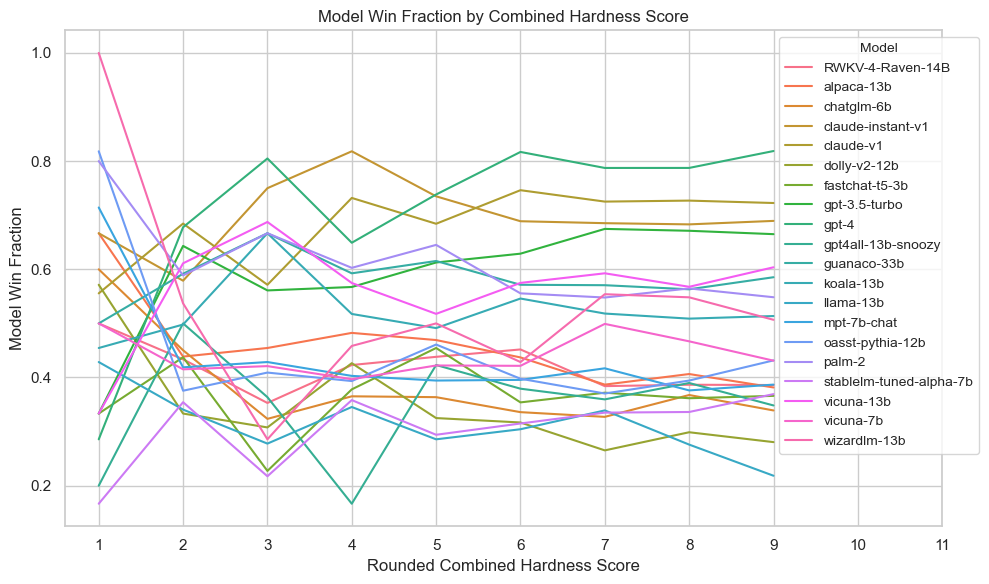

In [155]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=model_hardness_win_fracs, x='round_combined_hardness_score', y='win_frac', hue='model', ax=ax)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper right', fontsize='small', title_fontsize='small')
plt.xticks(np.arange(1, 12, 1))
plt.title('Model Win Fraction by Combined Hardness Score')
plt.ylabel('Model Win Fraction')
plt.xlabel('Rounded Combined Hardness Score')
plt.tight_layout()

In [105]:
merge_df.groupby(['round_combined_hardness_score', 'winning_model']).agg('size')
# merge_df.groupby(['round_combined_hardness_score', 'model_a']).agg('size') 
# + merge_df.groupby(['round_combined_hardness_score', 'model_b']).agg('size')

round_combined_hardness_score  winning_model          
1.0                            RWKV-4-Raven-14B             3
                               alpaca-13b                   4
                               chatglm-6b                   3
                               claude-instant-v1            2
                               claude-v1                    5
                                                         ... 
9.0                            palm-2                     136
                               stablelm-tuned-alpha-7b     89
                               vicuna-13b                 291
                               vicuna-7b                   97
                               wizardlm-13b                38
Length: 180, dtype: int64

In [111]:
merge_df.groupby(['round_combined_hardness_score'])[['model_a']].value_counts().reset_index(level=1)

,model_a,count
round_combined_hardness_score,,
1.0,vicuna-13b,7
1.0,gpt-4,6
1.0,koala-13b,6
1.0,claude-v1,5
1.0,dolly-v2-12b,4
...,...,...
9.0,dolly-v2-12b,105
9.0,llama-13b,86
9.0,gpt4all-13b-snoozy,48


In [115]:
merge_df[['model_a', 'model_b', 'winning_model', 'round_combined_hardness_score']]

,model_a,model_b,winning_model,round_combined_hardness_score
0,chatglm-6b,koala-13b,koala-13b,9.0
1,oasst-pythia-12b,alpaca-13b,alpaca-13b,8.0
2,koala-13b,oasst-pythia-12b,oasst-pythia-12b,3.0
3,vicuna-13b,oasst-pythia-12b,oasst-pythia-12b,8.0
4,vicuna-13b,koala-13b,vicuna-13b,2.0
...,...,...,...,...
25297,palm-2,chatglm-6b,palm-2,7.0
25298,alpaca-13b,claude-instant-v1,claude-instant-v1,2.0
25299,claude-instant-v1,guanaco-33b,claude-instant-v1,8.0
25300,guanaco-33b,koala-13b,guanaco-33b,8.0
